<a href="https://colab.research.google.com/github/ROYMASON11v1/CompuBlanda/blob/main/Criminalistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lógica difusa
- Nicolás Amaya
- Cristian Rodriguez
- Victor Betancourth

##Librerias

In [1]:
!pip install -U scikit-fuzzy # http://pythonhosted.org/scikit-fuzzy/auto_examples/index.html

In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

##Parametros del sistema

En nuestro ejercicio vamos medir el indice de criminalidad mediante varios parametros que son:
- Temperatura
- Hurtos
- Robos
- Homicidios

La lógica difusa con la que mediremos estos parametros será con:
- Bajo
- Medio
- Alto

###Definimos Temperatura


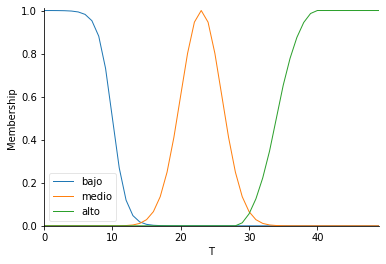

In [3]:
t = ctrl.Antecedent(np.arange(0, 50, 1), 'T')

t['bajo'] = fuzz.sigmf(t.universe, 10, -1)
t['medio'] = fuzz.gaussmf(t.universe, 23, 3)
t['alto']  = fuzz.pimf(t.universe, 28, 40, 50, 75)

t.view()

###Definimos Hurtos

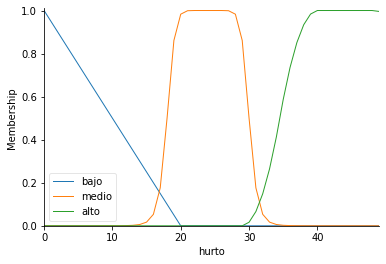

In [4]:
hur = ctrl.Antecedent(np.arange(0, 50, 1), 'hurto')

hur['bajo'] = fuzz.trimf(hur.universe, [0, 0, 20])
hur['medio'] = fuzz.gbellmf(hur.universe, 6, 5, 24)
hur['alto']  = fuzz.pimf(hur.universe, 29, 40, 48, 70)

hur.view()

###Definimos Robos

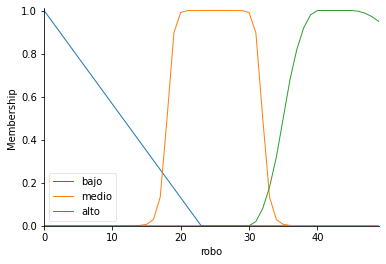

In [5]:
robo = ctrl.Antecedent(np.arange(0, 50, 1), 'robo')

robo['bajo'] = fuzz.trimf(robo.universe, [0, 0, 23])
robo['medio'] = fuzz.gbellmf(robo.universe, 7, 7, 25)
robo['alto']  = fuzz.pimf(robo.universe, 30, 40, 45, 70)

robo.view()

###Definimos Homicidios

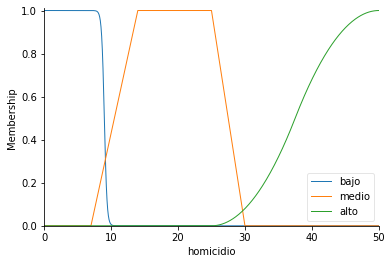

In [6]:
hom = ctrl.Antecedent(np.arange(0, 50.1, 0.1), 'homicidio')

hom['bajo'] = fuzz.sigmf(hom.universe, 9, -5)
hom['medio'] = fuzz.trapmf(hom.universe, [7, 14, 25, 30])
hom['alto']  = fuzz.pimf(hom.universe, 25, 50, 55, 70)

hom.view()

###Definimos Crimen (El parametro de estudio)

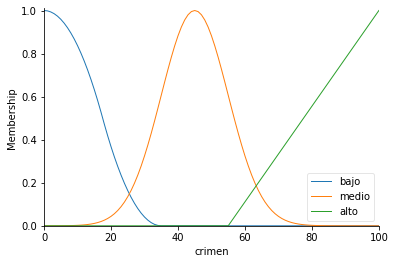

In [7]:
crim = ctrl.Consequent(np.arange(0, 101, 1), 'crimen')

crim['bajo'] = fuzz.zmf(crim.universe, 0, 35)
crim['medio'] = fuzz.gaussmf(crim.universe, 45, 10)
crim['alto']  = fuzz.trimf(crim.universe, [55, 100, 100])

crim.view()

##Reglas de la simulación 

Aqui definiremos las reglas que rigen el sistema del indice de crimen

In [8]:
rule1 = ctrl.Rule(robo['bajo']  & hur['bajo']  & hom['bajo'],                     crim['bajo'])
rule2 = ctrl.Rule((robo['medio'] | hur['medio']) & hom['bajo'],                   crim['medio'])
rule3 = ctrl.Rule((robo['alto']  | hur['alto'])  | (hom['alto'] | hom['medio']),  crim['alto'])
rule4 = ctrl.Rule(t['alto']| t['medio'],                                          crim['medio'])

Ahora definiremos el ssitema de control que se alimenta de las reglas y después creamos la simulación

In [9]:
# Creamos un sistema de control y una simulación
crim_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
crim_sim = ctrl.ControlSystemSimulation(crim_ctrl)

##Simulación

###Probamos nuestra simulación con un ejemplo

In [10]:
# Entradas de prueba
crim_sim.input['robo'] = 1
crim_sim.input['hurto'] = 50
crim_sim.input['homicidio'] = 5
crim_sim.input['T'] = 20

# Calculamos
crim_sim.compute()
crim_sim.output

OrderedDict([('crimen', 66.2104615056453)])

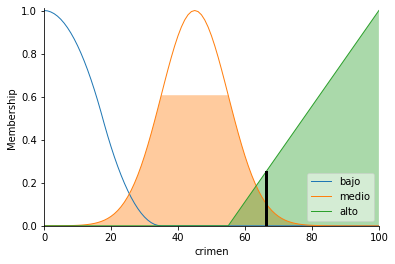

In [11]:
crim.view(sim=crim_sim)

##Aplicación del algoritmo

Aquí definimos una función la cual le entregaremos los parametros del sistemas para el calculo del indice del crimen

In [12]:
def ic(crim):
   # Entrada
   crim_sim.input['homicidio'] = crim[0]
   crim_sim.input['robo'] = crim[1]
   crim_sim.input['hurto'] = crim[2]
   crim_sim.input['T'] = crim[3]

   # Calcula
   crim_sim.compute()
   return(crim_sim.output['crimen'])

Prueba de la función

In [13]:
ic([10, 15, 2, 20])

60.58913791066639

Importamos la libreria pandas para interactuar con datos del mundo real (para crear el dataset)

In [14]:
import pandas as pd

Ahora vamos a importar unos datos estadisticos de pereira, para ver el algoritmo en funcionamiento

In [18]:
df = pd.read_excel('Crimenes.xlsx', sheet_name='PEREIRA')
df.set_index(['Year', 'Mes'])

Homicidio  Robo  Hurto  Temp
Year   Mes                              
2019.0 1           28    22     19    22
NaN    2           17    20     41    24
       3            0    17     75    22
       4           13    45     99    21
       5           28    52     79    19
       6            4    43     18    26
       7           36     5     72    27
       8           34    19     21    22
       9           16    17     14    27
       10          39    34     15    27
       11          34    52     85    26
       12           7     5     25    20
2020.0 1            4    32     19    27
NaN    2           10    17     60    25
       3           41     9     97    19
       4           13    12     12    20
       5           23    25     82    19
       6           13    34     56    27
       7           15    38     85    22
       8            0    21     77    19
       9            8    14     91    27
       10           6    16     82    26
       11          27    49     15    25
       12          21    13     77    23

Comprobar si extrajo los datos de la tabla correctamente (La primera temperatura)

In [20]:
df.loc[0,"Temp"]

22

Creamos una variable auxiliar para guardar los datos de cada mes de nuestra tabla

In [21]:
aux = df[["Homicidio", "Robo", "Hurto", "Temp"]]

Ahora creamos una nueva tabla junto con los nuevos datos calculados por nuestro algoritmo

In [22]:
aux["IC"] = aux.apply(ic, axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Aquí podemos evidenciar el resultado del algoritmo mostrando el indice del crimen de cada mes

In [23]:
aux

,Homicidio,Robo,Hurto,Temp,IC
0,28,22,19,22,58.203665
1,17,20,41,24,64.013047
2,0,17,75,22,64.012745
3,13,45,99,21,64.653003
4,28,52,79,19,68.858711
5,4,43,18,26,66.210778
6,36,5,72,27,68.858711
7,34,19,21,22,54.811552
8,16,17,14,27,68.859039
9,39,34,15,27,66.274713
